MLB 建模前資料處理

In [1]:
import sys
sys.path.append('G:\我的雲端硬碟\python')
import numpy as np
from polib.CsvEngn import *
from MLB_functions import *
from tqdm import tqdm

 **處理流程**

1. 確定所需球員範圍: 讀取2000~2020每年的球員表現數據(WAR (OPS+只有打者有先不加入)) from Baseball Reference
2. 定義合約年: 串接有簽約的自由球員狀態 from Baseball Reference
3. 變數製作: 串接相關欄位(球員 投打慣用手、國籍、初登板、最後出賽、年薪 from Lahman)、進階變數製作(明星賽入選次數、大聯盟年資六年平均表現)

# 確定所需球員範圍

讀取2000~2020每年的球員表現數據(WAR (OPS+只有打者有先不加入)) from Baseball Reference

In [2]:
# 整合投、打資料
BR_WAR_pitch_path = r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\2.baseball_reference\WAR_pitch_2000to2020_20210125_10.54.38.csv"
BR_WAR_bat_path = r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\2.baseball_reference\WAR_bat_2000to2020_20210125_10.52.44.csv"

BR_WAR_pitch_df = read_data_dir_fPathExt(BR_WAR_pitch_path)
BR_WAR_bat_df = read_data_dir_fPathExt(BR_WAR_bat_path)

  >> 讀取:: G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\2.baseball_reference\WAR_pitch_2000to2020_20210125_10.54.38.csv
  >> 讀取:: G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\2.baseball_reference\WAR_bat_2000to2020_20210125_10.52.44.csv


In [3]:
# 投、打的欄位有些許不同
print(">>pitch\n", BR_WAR_pitch_df.columns)
print(">>bat\n", BR_WAR_bat_df.columns)

>>pitch
 Index(['_idx', 'name_common', 'age', 'mlb_ID', 'player_ID', 'year_ID',
       'team_ID', 'stint_ID', 'lg_ID', 'G', 'GS', 'IPouts', 'IPouts_start',
       'IPouts_relief', 'RA', 'xRA', 'xRA_sprp_adj', 'xRA_extras_adj',
       'xRA_def_pitcher', 'PPF', 'PPF_custom', 'xRA_final', 'BIP', 'BIP_perc',
       'RS_def_total', 'runs_above_avg', 'runs_above_avg_adj',
       'runs_above_rep', 'RpO_replacement', 'GR_leverage_index_avg', 'WAR',
       'salary', 'teamRpG', 'oppRpG', 'pyth_exponent', 'waa_win_perc', 'WAA',
       'WAA_adj', 'oppRpG_rep', 'pyth_exponent_rep', 'waa_win_perc_rep',
       'WAR_rep', 'ERA_plus', 'ER_lg'],
      dtype='object')
>>bat
 Index(['_idx', 'name_common', 'age', 'mlb_ID', 'player_ID', 'year_ID',
       'team_ID', 'stint_ID', 'lg_ID', 'PA', 'G', 'Inn', 'runs_bat', 'runs_br',
       'runs_dp', 'runs_field', 'runs_infield', 'runs_outfield',
       'runs_catcher', 'runs_good_plays', 'runs_defense', 'runs_position',
       'runs_position_p', 'runs_replacement'

In [4]:
# 標記投打身分
BR_WAR_pitch_df.loc[:, "type"] = "pitch"
BR_WAR_bat_df.loc[:, "type"] = "bat"

# 留下需要的共同欄位 
BR_WAR_common_cols = [
                'name_common'
                ,'type'
                ,'age'
                ,'mlb_ID'
                ,'player_ID'
                ,'year_ID'
                ,'team_ID'
                ,'stint_ID'
                ,'lg_ID'
                ,'G'
                ,'WAR'
                ,'salary'
]

# 投、打分開取欄位 TODO
# BR_WAR_pitch_cols = BR_WAR_common_cols + ["ERA_plus"]
# BR_WAR_bat_cols = BR_WAR_common_cols + ["OPS_plus"]

BR_WAR_pitch_cols = BR_WAR_common_cols 
BR_WAR_bat_cols = BR_WAR_common_cols

# 合併投、打資料
BR_WAR_all_df = pd.concat([BR_WAR_pitch_df[BR_WAR_pitch_cols], BR_WAR_bat_df[BR_WAR_bat_cols]], sort=True)

# 篩選2000~2020資料
year_mask = BR_WAR_all_df['year_ID'].isin([y for y in range(2000, 2020+1)])
BR_WAR_all_df = BR_WAR_all_df[year_mask].reset_index(drop=True)

若球員一年中有在多個球隊打過就會有多筆stint_ID，如何整合WAR? >> 區分投打，做年度加總(有跨隊表現) 

>TODO : ERA+ 、OPS+ 的處理方式? >> 需要爬 BP 的 TOT >> 先暫緩製作(不加入)

## 從 LM Fielding Table，併入守備位置(position)

In [5]:
# 從 LM Fielding Table，併入守備位置(position)
LM_Fielding_path = r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\1.Lahman_db_2020\core\Fielding.csv"
LM_Fielding_df = read_data_dir_fPathExt(LM_Fielding_path)

  >> 讀取:: G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\1.Lahman_db_2020\core\Fielding.csv


In [6]:
mask_year_LM = LM_Fielding_df.loc[:, "yearID"].isin([y for y in range(2000,2020+1)])
LM_Fielding_df_pic = LM_Fielding_df.loc[mask_year_LM, ["playerID", "yearID", "POS", "G"]]
LM_Fielding_df_pic.sort_values(by=["yearID","playerID", "G"], ascending=[1,1,0], inplace=True)
a = len(LM_Fielding_df_pic)
LM_Fielding_df_pic_dedup = LM_Fielding_df_pic.drop_duplicates(subset=["playerID", "yearID"], keep="first")
b = len(LM_Fielding_df_pic_dedup)
print(b-a)

LM_Fielding_df_pic_dedup.columns = ['player_ID', 'year_ID', 'POS', 'G']

-11416


In [7]:
LM_Fielding_df_pic_dedup["POS"].unique()

array(['OF', 'SS', 'P', '3B', '2B', '1B', 'C'], dtype=object)

In [8]:
a = len(BR_WAR_all_df)
BR_WAR_all_df = BR_WAR_all_df.merge(LM_Fielding_df_pic_dedup[["year_ID","player_ID", "POS"]], 
                                    how="left", on=["year_ID","player_ID"])
b = len(BR_WAR_all_df)
print(f">> 撐開: {b-a} 筆")

print(f">> LM漏掉的POS比數: {BR_WAR_all_df.loc[:, 'POS'].isin([np.nan]).sum()} 筆")

>> 撐開: 0 筆
>> LM漏掉的POS比數: 877 筆


In [9]:
loss_POS_mask = (pd.isna(BR_WAR_all_df.loc[:, "POS"]))
loss_pos_some_year_platerID_lst = BR_WAR_all_df[loss_POS_mask]['player_ID'].unique()

In [10]:
print(f">> {len(loss_pos_some_year_platerID_lst)} 位球員有缺pos的紀錄")

>> 232 位球員有缺pos的紀錄


In [11]:
mask_find_pos = (pd.notna(BR_WAR_all_df.loc[:, "POS"])) \
                & (BR_WAR_all_df.loc[:, "player_ID"].isin(loss_pos_some_year_platerID_lst))
loss_POS_player_can_fill_lst = BR_WAR_all_df[mask_find_pos]['player_ID'].unique()
print(f">> 能用其他年資料捕的球員只有: {len(loss_POS_player_can_fill_lst)} 人")

# 進行填補
loss_POS_player_other_POS_df = BR_WAR_all_df[mask_find_pos][["player_ID", "POS", "G"]].sort_values(
                                by=["player_ID",  "G"], ascending=[1,0]).drop_duplicates(
                                subset=["player_ID"], keep="first")[["player_ID", "POS"]].reset_index(drop=True)

loss_POS_player_other_POS_dict = {}
for d in loss_POS_player_other_POS_df.to_dict("records"):
    loss_POS_player_other_POS_dict[d["player_ID"]] = d["POS"]

BR_WAR_all_df.loc[loss_POS_mask, "POS"] = BR_WAR_all_df.loc[loss_POS_mask, "player_ID"].apply(
                                                            lambda p: loss_POS_player_other_POS_dict[p] 
                                                            if p in loss_POS_player_can_fill_lst else np.nan)
print(f">> 填補後的POS缺值數: {(pd.isna(BR_WAR_all_df.loc[:, 'POS'])).sum()} 筆")

>> 能用其他年資料捕的球員只有: 138 人
>> 填補後的POS缺值數: 695 筆


In [12]:
# 掌握缺漏的playerID
still_loss_player_lst = BR_WAR_all_df[(pd.isna(BR_WAR_all_df.loc[:, 'POS']))]["player_ID"].unique()
print(f">> 填捕後還是漏的球員有: {len(still_loss_player_lst)} 人 >> 從 Baseball Reference 爬回來")

# 建立補值字典
fill_all_dict = {}
for t, i in enumerate(still_loss_player_lst):
    result = find_position(i)
    tmp_dict = {i:result}
    print(f">> ({t+1}/{len(still_loss_player_lst)})", tmp_dict)
    fill_all_dict.update(tmp_dict)


>> 填捕後還是漏的球員有: 94 人 >> 從 Baseball Reference 爬回來
>> (1/94) {'alexasc02': 'Pitcher'}
>> (2/94) {'beeksja02': 'Pitcher'}
>> (3/94) {'burnea.01': 'Pitcher'}
>> (4/94) {'campovi01': 'Pitcher'}
>> (5/94) {"d'amije01": 'Pitcher'}
>> (6/94) {"d'amije02": 'Pitcher'}
>> (7/94) {'davieza02': 'Pitcher'}
>> (8/94) {'dicker.01': 'Pitcher'}
>> (9/94) {'dygesje01': 'Pitcher'}
>> (10/94) {'garcifr03': 'Pitcher'}
>> (11/94) {'harriwi10': 'Pitcher'}
>> (12/94) {'jacquth01': 'Pitcher'}
>> (13/94) {"jimend'01": 'Second Baseman, Shortstop and Third Baseman'}
>> (14/94) {'jimenda01': 'Pitcher'}
>> (15/94) {'johnsma05': 'Pitcher'}
>> (16/94) {'lintz02': 'Shortstop, Second Baseman and Outfielder'}
>> (17/94) {'lockewa01': 'Pitcher'}
>> (18/94) {'lopezro02': 'Pitcher'}
>> (19/94) {'mathet.01': 'Pitcher'}
>> (20/94) {'montafr02': 'Pitcher'}
>> (21/94) {'morrija03': 'Pitcher'}
>> (22/94) {'murraco02': 'Pitcher'}
>> (23/94) {'nitkoc.01': 'Pitcher'}
>> (24/94) {"o'conbr02": 'Pitcher'}
>> (25/94) {'ortizra02': 'Pitc

In [13]:
# 清理 fill_all_dict
fill_all_dict_clean = {}
for key, value in fill_all_dict.items():
    if ("," in value) or ("and" in value):
        value = value.replace("and",",").split(",")[0]
        
#         ['OF', 'SS', 'P', '3B', '2B', '1B', 'C']
    if "Pitcher" in value:
        value = "P"
        
    elif "fielder" in value:
        value = "OF"
    
    elif "Shortstop" in value:
        value = "SS"
        
    elif "First Baseman" in value:
        value = "1B"
        
    elif "Second Baseman" in value:
        value = "2B"
        
    elif "Third Baseman" in value:
        value = "3B"
        
    elif "Catcher" in value:
        value = "C"
    
    fill_all_dict_clean[key] = value.strip()
    
loss_POS_mask_2 = (pd.isna(BR_WAR_all_df.loc[:, 'POS']))
BR_WAR_all_df.loc[loss_POS_mask_2, "POS"] = BR_WAR_all_df.loc[loss_POS_mask_2, "player_ID"].apply(
                                                        lambda p: fill_all_dict_clean[p] 
                                                        if p in still_loss_player_lst else np.nan)
print(f">> 二次填補後的POS缺值數: {(pd.isna(BR_WAR_all_df.loc[:, 'POS'])).sum()} 筆")


>> 二次填補後的POS缺值數: 0 筆


## 野手的投球不要記、投手的打擊不要記、代跑&指定打拿掉

In [14]:
mask_keep = ((BR_WAR_all_df["type"].isin(["pitch"])) & (BR_WAR_all_df["POS"].isin(["P"]))) \
            | ((BR_WAR_all_df["type"].isin(["bat"])) & (BR_WAR_all_df["POS"].isin(['OF', 'SS', '3B', '2B', '1B', 'C'])))
BR_WAR_all_df_pic_POS = BR_WAR_all_df[mask_keep].reset_index(drop=True)

In [15]:
len(BR_WAR_all_df)

44322

In [16]:
BR_WAR_all_df_pic_POS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29474 entries, 0 to 29473
Data columns (total 13 columns):
G              29474 non-null int64
WAR            29456 non-null float64
age            29474 non-null float64
lg_ID          29474 non-null object
mlb_ID         29474 non-null float64
name_common    29474 non-null object
player_ID      29474 non-null object
salary         17086 non-null float64
stint_ID       29474 non-null int64
team_ID        29474 non-null object
type           29474 non-null object
year_ID        29474 non-null int64
POS            29474 non-null object
dtypes: float64(4), int64(3), object(6)
memory usage: 2.9+ MB


## 從LM填補薪水並做CPI作平減

In [17]:
LM_salary_path = r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\1.Lahman_db_2020\core\Salaries.csv"
LM_salary_df = read_data_dir_fPathExt(LM_salary_path)

  >> 讀取:: G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\1.Lahman_db_2020\core\Salaries.csv


In [18]:
merge_key_cols_lst = ['year_ID', 'team_ID', 'lg_ID', 'player_ID']
LM_salary_df.columns = merge_key_cols_lst + ["salary"]

BR_WAR_all_df_pic_POS = BR_WAR_all_df_pic_POS.merge(
                LM_salary_df, how="left", on=merge_key_cols_lst, suffixes=("_BR","_LM"))

In [19]:
# 檢查 BR缺值，LM可填補的數量
salary_BR_nan_df = BR_WAR_all_df_pic_POS[pd.isna(BR_WAR_all_df_pic_POS["salary_BR"])]
salary_BR_nan_LM_fill_df = salary_BR_nan_df[pd.notna(salary_BR_nan_df["salary_LM"])]
print(f">> salary_BR 缺值: {len(salary_BR_nan_df)}， LM 可填補: {len(salary_BR_nan_LM_fill_df)}")
# 檢查 BR、LM皆有值但不同的數量
salary_BR_Notnan_df = BR_WAR_all_df_pic_POS[pd.notna(BR_WAR_all_df_pic_POS["salary_BR"])]
salary_BR_LM_diff_mask = (pd.notna(salary_BR_Notnan_df["salary_LM"]))&(salary_BR_Notnan_df["salary_BR"]!=salary_BR_Notnan_df["salary_LM"])
salary_BR_LM_diff_df = salary_BR_Notnan_df[salary_BR_LM_diff_mask]
print(f">> salary_BR、salary_LM 有值，但不同的資料: {len(salary_BR_LM_diff_df)}")

>> salary_BR 缺值: 12388， LM 可填補: 141
>> salary_BR、salary_LM 有值，但不同的資料: 194


BR、LM 薪水不同，已最高的為主

In [20]:
BR_WAR_all_df_pic_POS.loc[:,"salary_max"] = BR_WAR_all_df_pic_POS[["salary_BR","salary_LM"]].apply(lambda row: row.max(), axis=1)

In [21]:
print(f">>缺少薪水資料的比例: {round(pd.isna(BR_WAR_all_df_pic_POS.loc[:,'salary_max']).sum()/len(BR_WAR_all_df_pic_POS),2)}")

>>缺少薪水資料的比例: 0.42


In [22]:
BR_WAR_all_df_pic_POS[pd.isna(BR_WAR_all_df_pic_POS.loc[:,'salary_max'])][["year_ID","player_ID"]]

,year_ID,player_ID
1,2006,aardsda01
7,2013,aardsda01
8,2015,aardsda01
9,2010,abadfe01
12,2013,abadfe01
...,...,...
29462,2003,zoccope01
29463,2000,zoskyed01
29464,2000,zuletju01
29466,2013,zuninmi01


### 薪水的缺值如何處理?(TODO)

依美國CPI進行平減，[資料來源](https://data.bls.gov/pdq/SurveyOutputServlet)

In [23]:
US_CPI_path = r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\99_others\US_CPI_2000to2020.csv"
US_CPI_df = read_data_dir_fPathExt(US_CPI_path)

US_CPI_df["deflator_rate"] = US_CPI_df["Jun"].apply(lambda j: round(j/US_CPI_df["Jun"][0],4)) #基期 2000年
US_CPI_dict = dict(zip(US_CPI_df.Year, US_CPI_df.deflator_rate))

  >> 讀取:: G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\99_others\US_CPI_2000to2020.csv


In [24]:
# 依2000年美國CPI進行平減
BR_WAR_all_df_pic_POS.loc[:, "salary_max_delf"] = BR_WAR_all_df_pic_POS.apply(
            lambda row: round(row["salary_max"]/US_CPI_dict[row["year_ID"]])
            if pd.notna(row["salary_max"]) else np.nan, axis=1)

In [ ]:
# 以百萬美元為單位
BR_WAR_all_df_pic_POS.loc[:, "salary_max_delf"] = BR_WAR_all_df_pic_POSloc[:,"salary_max_delf"]/10**6

## WAR年度跨隊加總>> 以當年最高薪球隊為代表

In [25]:
# # WAR空值>> 直接刪除
# a = len(BR_WAR_all_df_pic_POS)
# BR_WAR_all_df_pic_POS.dropna(subset=['WAR'], inplace=True)
# b = len(BR_WAR_all_df_pic_POS)
# print(f">> 刪除WAR為空值的資料: {a-b}筆")

# 依照 年份、球員ID、投打type 來加總WAR
gp_cols = ["year_ID" ,"player_ID" ,"type"]
BR_WAR_all_gp = BR_WAR_all_df_pic_POS[gp_cols+["WAR"]].groupby(gp_cols).agg("sum").reset_index()
# BR_WAR_all_gp

# 加總後取唯一一筆球隊，以salary最高來判斷
BR_WAR_all_OneTeam_df = BR_WAR_all_df_pic_POS.sort_values(by=gp_cols+["salary_max_delf"], ascending=[1,1,1,0]).drop_duplicates(subset=gp_cols).reset_index(drop=True)
BR_WAR_all_OneTeam_df.drop(columns=["WAR"], inplace=True)

# 將加總後的WAR合併回OneTime df
BR_WAR_all_OneTeam_df = BR_WAR_all_OneTeam_df.merge(BR_WAR_all_gp, how="left", on=gp_cols)

In [26]:
BR_WAR_all_OneTeam_df[BR_WAR_all_OneTeam_df['stint_ID']>1].sort_values(by=["player_ID", "year_ID"])

,G,age,lg_ID,mlb_ID,name_common,player_ID,salary_BR,stint_ID,team_ID,type,year_ID,POS,salary_LM,salary_max,salary_max_delf,WAR
20231,18,30.0,AL,472551.0,Fernando Abad,abadfe01,1250000.0,2,BOS,pitch,2016,P,NaN,1250000.0,894134.0,0.78
11176,3,32.0,AL,275700.0,Winston Abreu,abreuwi01,NaN,2,CLE,pitch,2009,P,NaN,NaN,NaN,-0.17
24327,13,32.0,AL,542866.0,Austin Adams,adamsau01,NaN,2,DET,pitch,2019,P,NaN,NaN,NaN,0.01
24328,29,28.0,AL,613534.0,Austin Adams,adamsau02,NaN,2,SEA,pitch,2019,P,NaN,NaN,NaN,0.62
21589,100,28.0,NL,571431.0,Matt Adams,adamsma01,2800000.0,2,ATL,bat,2017,1B,NaN,2800000.0,1970582.0,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25701,17,25.0,AL,621056.0,Hunter Wood,woodhu01,NaN,2,CLE,pitch,2019,P,NaN,NaN,NaN,0.44
22918,11,30.0,NL,475243.0,Travis Wood,woodtr01,4000000.0,2,SDP,pitch,2017,P,NaN,4000000.0,2815117.0,-1.68
12415,13,33.0,AL,218595.0,Chris Woodward,woodwch01,NaN,2,BOS,bat,2009,3B,NaN,NaN,NaN,0.04
17557,1,30.0,AL,489448.0,Mike Zagurski,zagurmi01,NaN,2,NYY,pitch,2013,P,NaN,NaN,NaN,-0.50


In [27]:
# 同年跨隊檢查與比較
palyer_name = "Oliver Drake"
# Oliver Drake
# Shohei Ohtani
# Dan Miceli

mask = BR_WAR_all_df["name_common"].isin([palyer_name])
BR_WAR_all_df[mask].sort_values(by=["year_ID"])

mask = BR_WAR_all_OneTeam_df["name_common"].isin([palyer_name])
BR_WAR_all_OneTeam_df[mask].sort_values(by=["year_ID"])

# BR_WAR_all_df_pic_POS[BR_WAR_all_df_pic_POS['stint_ID']>3]
BR_WAR_all_OneTeam_df.head()

,G,age,lg_ID,mlb_ID,name_common,player_ID,salary_BR,stint_ID,team_ID,type,year_ID,POS,salary_LM,salary_max,salary_max_delf,WAR
0,80,27.0,AL,110010.0,Jeff Abbott,abbotje01,255000.0,1,CHW,bat,2000,OF,NaN,255000.0,255000.0,-0.28
1,79,31.0,NL,110011.0,Kurt Abbott,abbotku01,500000.0,1,NYM,bat,2000,SS,NaN,500000.0,500000.0,-0.41
2,35,32.0,AL,110015.0,Paul Abbott,abbotpa01,285000.0,1,SEA,pitch,2000,P,285000.0,285000.0,285000.0,2.57
3,154,26.0,NL,110029.0,Bobby Abreu,abreubo01,2933333.0,1,PHI,bat,2000,OF,2933333.0,2933333.0,2933333.0,6.18
4,62,30.0,NL,110032.0,Juan Acevedo,aceveju01,612500.0,1,MIL,pitch,2000,P,612500.0,612500.0,612500.0,0.86


## 需要完整年資，而非只有簽約年的球員!

In [28]:
# 讀BR原始資料
BR_WAR_bat_org_path = r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\2.baseball_reference\org\WAR_bat_org_20210307_18.24.25.csv"
BR_WAR_pitch_org_path = r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\2.baseball_reference\org\WAR_pitch_org_20210307_18.24.47.csv"

BR_WAR_bat_org_df = read_data_dir_fPathExt(BR_WAR_bat_org_path)
BR_WAR_pitch_org_df = read_data_dir_fPathExt(BR_WAR_pitch_org_path)

  >> 讀取:: G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\2.baseball_reference\org\WAR_bat_org_20210307_18.24.25.csv
  >> 讀取:: G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\2.baseball_reference\org\WAR_pitch_org_20210307_18.24.47.csv


In [29]:
BR_WAR_all_org_dup_df = pd.concat(
    [BR_WAR_bat_org_df[["player_ID", "year_ID"]],
     BR_WAR_pitch_org_df[["player_ID", "year_ID"]]]).drop_duplicates(keep="first")

In [30]:
BR_WAR_all_org_dup_uni_year = BR_WAR_all_org_dup_df.year_ID.unique()
BR_WAR_all_org_dup_uni_year[BR_WAR_all_org_dup_uni_year>2019] # 最大就2020年

array([2020], dtype=int64)

In [31]:
# 推論年資
# 方法1:BR_WAR_all_OneTeam_df(G)=0的球員>> 無，一定有當年出賽，以出賽年數計算年資

# 比對當年年資方法
def count_Yrs_by_BRorg(playerID, year):
    mask = (BR_WAR_all_org_dup_df["player_ID"].isin([playerID])) & (BR_WAR_all_org_dup_df["year_ID"]<=year)
    BR_WAR_all_org_dup_df_pic = BR_WAR_all_org_dup_df[mask].reset_index(drop=True)
    return BR_WAR_all_org_dup_df_pic.groupby("player_ID").count().values[0][0]

In [32]:
len(BR_WAR_all_OneTeam_df)

27016

In [33]:
# 要跑 8分鐘10秒!! 2021.03.13 待優化 TODO
Yrs_lst = []
for playerID, year in tqdm(zip(BR_WAR_all_OneTeam_df.player_ID, BR_WAR_all_OneTeam_df.year_ID)):
    Yrs_lst.append(count_Yrs_by_BRorg(playerID=playerID, year=year))

27016it [08:10, 55.11it/s]


In [37]:
BR_WAR_all_OneTeam_df.loc[:, "Yrs_BR"] = Yrs_lst

# 定義合約年

串接有簽約的自由球員狀態 from Baseball Reference

In [2]:
# 讀取自由球員資料
BP_FA_path = r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\5.free_agent_collection\BR_FreeAgent_2000to2020_20210208_18.02.07.csv"
BP_FA_df = read_data_dir_fPathExt(BP_FA_path)

  >> 讀取:: G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\5.free_agent_collection\BR_FreeAgent_2000to2020_20210208_18.02.07.csv


In [3]:
BP_FA_df.rename(columns={"Yrs":"Yrs_FA"}, inplace=True)

In [5]:
BP_FA_df.columns

Index(['_idx', 'AB', 'Age', 'BA', 'BB', 'BB.1', 'Date', 'ERA', 'From Team',
       'G', 'G.1', 'GS', 'H', 'H.1', 'HR', 'HR.1', 'IP', 'L', 'Name', 'OBP',
       'OPS', 'R', 'RBI', 'Rk', 'SB', 'SLG', 'SO', 'SV', 'To Team', 'W',
       'WAR3', 'WHIP', 'YEAR', 'Yrs_FA'],
      dtype='object')

In [8]:
# BP_FA_df[BP_FA_df["Yrs_FA"]==5][["Name","YEAR"]]

In [42]:
BP_FA_df['Yrs_FA'].value_counts()

2     953
3     858
7     852
4     837
5     833
6     780
1     768
8     717
9     573
10    428
11    346
12    276
13    198
14    147
15    118
16     77
17     44
18     32
19     22
20     12
21     11
22      7
23      3
24      1
0       1
Name: Yrs_FA, dtype: int64

只看年資6年以上的簽約就好

In [43]:
check_FA_Yrs_gt_6_mask = BP_FA_df['Yrs_FA']>=6
BP_FA_df_pic = BP_FA_df[check_FA_Yrs_gt_6_mask].reset_index(drop=True)

In [44]:
len(BP_FA_df)

8894

In [45]:
BP_FA_df_pic.info()
# Yrs: 大聯盟年資

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4644 entries, 0 to 4643
Data columns (total 34 columns):
_idx         4644 non-null int64
AB           4174 non-null float64
Age          4644 non-null int64
BA           4058 non-null float64
BB           4174 non-null float64
BB.1         2115 non-null float64
Date         4644 non-null object
ERA          2115 non-null float64
From Team    4644 non-null object
G            4174 non-null float64
G.1          2115 non-null float64
GS           2115 non-null float64
H            4174 non-null float64
H.1          2115 non-null float64
HR           4174 non-null float64
HR.1         2115 non-null float64
IP           2115 non-null float64
L            2115 non-null float64
Name         4644 non-null object
OBP          4071 non-null float64
OPS          4058 non-null float64
R            4174 non-null float64
RBI          4174 non-null float64
Rk           4644 non-null int64
SB           4174 non-null float64
SLG          4058 non-null 

同年又同名同姓的FA交易紀錄(ex: 2014、2015 Chris Young)>> 需加入球隊來區別

In [123]:
# 以Lahman Team 資料 將 To Team 替換成team ID
LM_team_path = r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\1.Lahman_db_2020\core\Teams.csv"
LM_team_df = read_data_dir_fPathExt(LM_team_path) 

# 製作 球隊全名:簡稱 字典
LM_team_df_for_ID = LM_team_df[['name', 'teamIDBR']].drop_duplicates()
teamID_dict = dict(zip(LM_team_df_for_ID.name, LM_team_df_for_ID.teamIDBR))

# 例外處裡: Los Angeles Angels of Anaheim = Los Angeles Angels
mask_fix = BP_FA_df_pic['To Team'].isin(['Los Angeles Angels of Anaheim'])
BP_FA_df_pic.loc[mask_fix, 'To Team'] = "Los Angeles Angels"

# 以球隊名稱串簡稱
BP_FA_df_pic['To Team ID'] = BP_FA_df_pic['To Team'].apply(lambda t: teamID_dict[t] if pd.notna(t) else np.nan)

# 球隊名稱清理
# FLA => MIA 馬林魚 需整合
# SFG>>巨人隊
# KCR>>皇家隊
# BLA(誤)>>BAL 金鶯隊 需更正
# SDP>>教士隊
# TBRD => TBRR 光芒隊 需整合
# ANA => LAA 天使隊 需整合
# CHW>>白襪隊
# MLA>>釀酒人隊
#  MON => WSN 國民隊 需整合

def team_ID_cleaner(teamID):
    if teamID == "FLA":
        return "MIA"
    
    if (teamID == "TBRD") | (teamID == "TBR"):
        return "TBRR"
    
    if teamID == "ANA":
        return "LAA"
    
    if (teamID == "MON") | (teamID == "WSN"):
        return "WSN"
    
    if teamID == "BLA":
        return "BAL"
    
    return teamID
    
for c in ["From Team", "To Team ID"]:
    BP_FA_df_pic[c] = BP_FA_df_pic[c].apply(team_ID_cleaner)

print(f">> MLB球隊數: {BP_FA_df_pic['To Team ID'].nunique()} 隊 (理應30隊)")

  >> 讀取:: G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\1.Lahman_db_2020\core\Teams.csv
>> MLB球隊數: 30 隊 (理應30隊)


FA紀錄在To Team為空值(37筆)>> 人肉查詢

In [125]:
FA_cols_pic_tmp = ["YEAR", "Date", "Name", "From Team", "To Team ID", "Yrs_FA"]

# 檢查 37筆都是真的有FA紀錄的球員
FA_check_ToTeam_nan_mask = pd.isna(BP_FA_df_pic['To Team ID'])
FA_check_ToTeam_nan_df = BP_FA_df_pic[FA_check_ToTeam_nan_mask][FA_cols_pic_tmp]
print(f">> FA紀錄在To Team為空值: {len(FA_check_ToTeam_nan_df)} 筆")

>> FA紀錄在To Team為空值: 23 筆


## To Team 缺值檢查


|簽約年(列表)|簽約日期_人名|檢查結果|
|:--|:--|:--|
|2004|2005-04-01_Andy Fox|簽給天使同年退休且簽約前年無出賽，補(LAA)|
|2004|2005-02-23_Carlos Baerga|簽給國民，當年有93場出賽紀錄，補(WSN)|
|2004|2005-02-21_Luke Allen|同年簽給天使且簽約前年無出賽，補(LAA)|
|2004|2005-02-18_Hector Ortiz|簽給國民，隨後消失，補(WSN)|
|2004|2005-02-15_Lou Merloni|簽給天使，當年有5場出賽紀錄，補(LAA)|
|2004|2005-01-19_Esteban Loaiza|簽給國民，當年有34場出賽紀錄，補(WSN)|
|2004|2005-01-19_Antonio Osuna|簽給國民，當年有4場出賽紀錄，補(WSN)|
|2004|2005-01-18_Keith Osik|簽給國民，當年有5場出賽紀錄，補(WSN)|
|2004|2005-01-12_Orlando Cabrera|簽給天使，當年有140場出賽紀錄，補(LAA)|
|2004|2005-01-11_Corey Lee|簽給天使，同年釋出且簽約前年無出賽，補(LAA)|
|2004|2005-01-11_Brian Powell|簽給國民，隨後消失，補(WSN)|
|2004|2005-01-05_Matt White|簽給國民，補(WSN)|
|2004|2005-01-05_Ed Yarnall|簽給國民，補(WSN)|
|2004|2005-01-03_Erick Almonte|原日職選手，簽給印地安人，補(CLE)|
|2004|2004-12-23_Chad Durbin|簽給國民，補(WSN)|
|2004|2004-12-23_Phil Hiatt|簽給國民，補(WSN)|
|2004|2004-12-23_Luis Pineda|簽給國民，補(WSN)|
|2004|2004-12-20_Aaron Myette|原日職選手，簽給費城人，補(PHI)|
|2004|2004-12-13_Wil Cordero|簽給國民，補(WSN)|
|2004|2004-11-29_Gary Bennett|簽給國民，補(WSN)|
|2004|2004-11-16_Vinny Castilla|簽給國民，補(WSN)|
|2004|2004-11-16_Cristian Guzman|簽給國民，補(WSN)|
|2004|2004-11-04_Ramon Castro|簽給國民，補(WSN)|
|2004|2004-10-28_Dan Smith|簽給國民，但隨後消失，補(WSN)|
|2007|2008-04-22_Josh Labandeira|簽給光芒，補(TBR)|
|2007|2008-03-29_Ben Hendrickson|簽給光芒，補(TBR)|
|2007|2008-02-06_Eric Hinske|簽給光芒，補(TBR)|
|2007|2008-02-06_Trever Miller|簽給光芒，補(TBR)|
|2007|2008-02-01_Steve Andrade|簽給光芒，補(TBR)|
|2007|2008-01-06_Mike Difelice|簽給光芒，補(TBR)|
|2007|2008-01-04_Brent Butler|簽給光芒，補(TBR)|
|2007|2008-01-03_John Rodriguez|簽給光芒，補(TBR)|
|2011|2012-01-20_Chris Aguila|簽給馬林魚，補(MIA)|
|2011|2012-01-18_Gil Velazquez|簽給馬林魚，補(MIA)|
|2011|2012-01-05_Greg Dobbs|簽給馬林魚，補(MIA)|
|2011|2012-01-04_Rob Delaney|簽給馬林魚，補(MIA)|
|2011|2012-01-04_Chad Gaudin|簽給馬林魚，補(MIA)|

In [153]:
# 讀入補值資料
FA_fillnan_ToTeam_path = r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\5.free_agent_collection\fill_no_toTeam_37players.csv"
FA_fillnan_ToTeam_df = read_data_dir_fPathExt(FA_fillnan_ToTeam_path)

FA_fillnan_dict =  dict(zip(FA_fillnan_ToTeam_df.id, FA_fillnan_ToTeam_df.to_team))

  >> 讀取:: G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\5.free_agent_collection\fill_no_toTeam_37players.csv


In [154]:
# 補植
BP_FA_df_pic.loc[FA_check_ToTeam_nan_mask, "To Team ID"] = BP_FA_df_pic.loc[FA_check_ToTeam_nan_mask][["Date","Name"]].apply(
                                lambda row: FA_fillnan_dict[str(row["Date"]) +"_"+str(row["Name"])], axis=1)

簽約年使用列表年，而非簽約日期的年度(考量球季時間)

In [155]:
# 檢查FA重複
check_dup = (BP_FA_df_pic["YEAR"].map(str) + "_" + BP_FA_df_pic["From Team"] + "_" + BP_FA_df_pic["Name"]).value_counts()
print(check_dup[check_dup>1]) # millema02、millema01

# 例外處理: 2003_COL_Matt Miller
# 實際上2003年有表現數據的只有millema02
mask = (BR_WAR_all_OneTeam_df["year_ID"].isin([2003])) & (BR_WAR_all_OneTeam_df["name_common"].isin(["Matt Miller"]))
print(BR_WAR_all_OneTeam_df[mask])

# 拿掉 millema01 在FA名單中: 簽約日 2004-01-05
drop_millema01_mask = (BP_FA_df_pic["Date"].isin(["2004-01-05"])) & (BP_FA_df_pic["Name"].isin(["Matt Miller"]))
BP_FA_df_pic = BP_FA_df_pic[~drop_millema01_mask].reset_index(drop=True)

Series([], dtype: int64)
      G   age lg_ID    mlb_ID  name_common  player_ID  salary_BR  stint_ID  \
4384  4  31.0    NL  285080.0  Matt Miller  millema02        NaN         1   

     team_ID   type  year_ID POS  salary_LM  salary_max  salary_max_delf  WAR  \
4384     COL  pitch     2003   P        NaN         NaN              NaN  0.1   

      Yrs_BR                FA_key  
4384       1  2003_COL_Matt Miller  


合併

In [156]:
# 合約年格式轉換為整數
BP_FA_df_pic["YEAR"] = BP_FA_df_pic["YEAR"].map(int)

# 標記簽約FA
BP_FA_df_pic['is_FA_signed'] = True

# FA 資料排除沒有 To Team 紀錄的資料
mask_ToTeam_notna = pd.notna(BP_FA_df_pic['To Team ID'])
BP_FA_df_pic = BP_FA_df_pic[mask_ToTeam_notna].reset_index(drop=True)

# 製作key
BP_FA_df_pic["FA_key"] = BP_FA_df_pic["YEAR"].map(str) + "_" + BP_FA_df_pic["From Team"] + "_" + BP_FA_df_pic["Name"]
BR_WAR_all_OneTeam_df["FA_key"] = BR_WAR_all_OneTeam_df["year_ID"].map(str) + "_" + BR_WAR_all_OneTeam_df["team_ID"] + "_" + BR_WAR_all_OneTeam_df["name_common"]

# 以FA簽約年、簽約年的原球隊(from team)、球員名稱串檔
FA_cols_pic = ["Date", "To Team ID", "Yrs_FA", "is_FA_signed", "FA_key"]
BR_WAR_all_FA_df = BR_WAR_all_OneTeam_df.merge(BP_FA_df_pic[FA_cols_pic], how="left"
                    , on=["FA_key"])

# 空值處理
BR_WAR_all_FA_df.fillna(np.nan, inplace=True)
BR_WAR_all_FA_df['is_FA_signed'].fillna(False, inplace=True)

print(f">>撐開: {len(BR_WAR_all_FA_df)-len(BR_WAR_all_OneTeam_df)} 筆")

>>撐開: 0 筆


In [157]:
BR_WAR_all_FA_df['is_FA_signed'].value_counts()

False    24108
True      2908
Name: is_FA_signed, dtype: int64

In [158]:
# 檢查年資 >> Yrs_BR 完勝 Yrs_FA
# check_Yrs_same_mask= (pd.notna(BR_WAR_all_FA_df["Yrs_FA"])) & (BR_WAR_all_FA_df["Yrs_FA"]==BR_WAR_all_FA_df["Yrs_BR"])
# BR_WAR_all_FA_df[check_Yrs_same_mask]

check_Yrs_diff_mask= (pd.notna(BR_WAR_all_FA_df["Yrs_FA"])) & (BR_WAR_all_FA_df["Yrs_FA"]!=BR_WAR_all_FA_df["Yrs_BR"])
BR_WAR_all_FA_df[check_Yrs_diff_mask]

,G,age,lg_ID,mlb_ID,name_common,player_ID,salary_BR,stint_ID,team_ID,type,...,salary_LM,salary_max,salary_max_delf,WAR,Yrs_BR,FA_key,Date,To Team ID,Yrs_FA,is_FA_signed
532,11,28.0,NL,116718.0,Bobby Jones,jonesbo04,NaN,1,NYM,pitch,...,NaN,NaN,NaN,0.12,4,2000_NYM_Bobby Jones,2001-02-15,SDP,8.0,True


# 變數製作

串接相關欄位(球員 投打慣用手、國籍、初登板、最後出賽 from Lahman)

In [159]:
LM_people_path = r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\1.Lahman_db_2020\core\People.csv"
LM_people_df = read_data_dir_fPathExt(LM_people_path)

LM_AllStar_path = r"G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\1.Lahman_db_2020\core\AllstarFull.csv"
LM_AllStar_df = read_data_dir_fPathExt(LM_AllStar_path)

  >> 讀取:: G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\1.Lahman_db_2020\core\People.csv
  >> 讀取:: G:\我的雲端硬碟\learning\論文今年會寫完\0.資源包\2.資料\1.Lahman_db_2020\core\AllstarFull.csv


In [160]:
LM_people_df.columns

Index(['playerID', 'birthYear', 'birthMonth', 'birthDay', 'birthCountry',
       'birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathDay',
       'deathCountry', 'deathState', 'deathCity', 'nameFirst', 'nameLast',
       'nameGiven', 'weight', 'height', 'bats', 'throws', 'debut', 'finalGame',
       'retroID', 'bbrefID'],
      dtype='object')

In [161]:
# 組合成常見的名子(也可以用player)ID就好)
LM_people_df['name_common'] = LM_people_df["nameFirst"] + " "+ LM_people_df["nameLast"]

In [162]:
LM_people_cols_pic = [
    'player_ID'
#     ,'name_common'
#     ,'birthYear'
#     ,'birthMonth'
#     ,'birthDay'
#     ,'birthCountry'
#     ,'birthState'
#     ,'birthCity'
#     ,'deathYear'
#     ,'deathMonth'
#     ,'deathDay'
#     ,'deathCountry'
#     ,'deathState'
#     ,'deathCity'
#     ,'nameFirst'
#     ,'nameLast'
#     ,'nameGiven'
#     ,'weight'
#     ,'height'
    ,'bats'
    ,'throws'
    ,'debut'
    ,'finalGame'
#     ,'retroID'
#     ,'bbrefID'
]

# 以 player_ID 串檔
LM_people_df.rename(columns={"playerID":"player_ID"}, inplace=True)
BR_WAR_all_FA_df = BR_WAR_all_FA_df.merge(LM_people_df[LM_people_cols_pic], how="left"
                    , on=["player_ID"])

# 空值處理
BR_WAR_all_FA_df.fillna(np.nan, inplace=True)

初登板、最後登板資料有空值 >> 從 Baseball Reference 爬回來

In [163]:
# 掌握缺漏的playerID
no_match_platerID_lst = BR_WAR_all_FA_df[pd.isna(BR_WAR_all_FA_df["debut"])]["player_ID"].unique()
print(len(no_match_platerID_lst))

# 建立補值字典
fill_all_dict = {}
for t, i in enumerate(no_match_platerID_lst):
    result = find_debut_lastgame(i)
    tmp_dict = {i:{"debut":result[0], "last_game":result[1]}}
    print(f">> ({t+1}/{len(no_match_platerID_lst)})", tmp_dict)
    fill_all_dict.update(tmp_dict)
    
# fill_all_dict

64
>> (1/64) {'brownro02': {'debut': '1999-05-18', 'last_game': '2002-09-29'}}
>> (2/64) {'burnea.01': {'debut': '1999-08-17', 'last_game': '2015-10-03'}}
>> (3/64) {"d'amije01": {'debut': '1996-06-28', 'last_game': '2004-05-10'}}
>> (4/64) {"d'amije02": {'debut': '2000-06-03', 'last_game': '2000-07-07'}}
>> (5/64) {'drewj.01': {'debut': '1998-09-08', 'last_game': '2011-09-28'}}
>> (6/64) {'furcara02': {'debut': '2000-04-04', 'last_game': '2014-06-21'}}
>> (7/64) {'garcifr03': {'debut': '1999-04-07', 'last_game': '2013-09-24'}}
>> (8/64) {'hincha.01': {'debut': '1998-04-01', 'last_game': '2004-09-24'}}
>> (9/64) {'jacquth01': {'debut': '2000-09-09', 'last_game': '2000-09-30'}}
>> (10/64) {'johnsma05': {'debut': '2000-04-07', 'last_game': '2000-06-24'}}
>> (11/64) {'lopezro02': {'debut': '2000-04-29', 'last_game': '2012-04-22'}}
>> (12/64) {'mathet.01': {'debut': '1995-07-28', 'last_game': '2002-07-24'}}
>> (13/64) {'morrija03': {'debut': '1999-09-18', 'last_game': '2000-05-09'}}
>> (14

In [164]:
# 用字典補回去
loss_mask = BR_WAR_all_FA_df.loc[:, "player_ID"].isin(no_match_platerID_lst)
BR_WAR_all_FA_df.loc[loss_mask, "debut"] = BR_WAR_all_FA_df.loc[loss_mask, "player_ID"].apply(lambda _id:  fill_all_dict[_id]['debut'])
BR_WAR_all_FA_df.loc[loss_mask, "finalGame"] = BR_WAR_all_FA_df.loc[loss_mask, "player_ID"].apply(lambda _id:  fill_all_dict[_id]['last_game'])

In [165]:
# LM_people_df[LM_people_df["player_ID"].isin(no_match_platerID_lst)]

In [166]:
BR_WAR_all_FA_df.columns

Index(['G', 'age', 'lg_ID', 'mlb_ID', 'name_common', 'player_ID', 'salary_BR',
       'stint_ID', 'team_ID', 'type', 'year_ID', 'POS', 'salary_LM',
       'salary_max', 'salary_max_delf', 'WAR', 'Yrs_BR', 'FA_key', 'Date',
       'To Team ID', 'Yrs_FA', 'is_FA_signed', 'bats', 'throws', 'debut',
       'finalGame'],
      dtype='object')

## is_最後出賽年

In [167]:
BR_WAR_all_FA_df["is_finalGame_year"] = BR_WAR_all_FA_df.apply(
    lambda row: row['year_ID']==(int(row['finalGame'].split("-")[0])) 
    if pd.notna(row['finalGame']) else False, axis=1)

In [168]:
BR_WAR_all_FA_df["is_finalGame_year"].value_counts()

False    21225
True      5791
Name: is_finalGame_year, dtype: int64

## 年齡平方

In [169]:
# 製作age平方 (age2)
BR_WAR_all_FA_df["age2"] = BR_WAR_all_FA_df["age"]*BR_WAR_all_FA_df["age"]

## 入明星賽次數 ~2020

In [170]:
LM_AllStar_df.columns

Index(['playerID', 'yearID', 'gameNum', 'gameID', 'teamID', 'lgID', 'GP',
       'startingPos'],
      dtype='object')

In [171]:
LM_AllStar_df.drop_duplicates(subset=["playerID","yearID"], keep="first", inplace=True)

In [172]:
# LM_AllStar_df[LM_AllStar_df["playerID"].isin(["aaronha01"])]

In [173]:
LM_AllStar_times_df = LM_AllStar_df.groupby("playerID").count().reset_index()
LM_AllStar_times_dict = dict(zip(LM_AllStar_times_df.playerID, LM_AllStar_times_df.yearID))

In [174]:
BR_WAR_all_FA_df.loc[:,"Allstar_times"] = BR_WAR_all_FA_df.loc[:,"player_ID"].apply(
    lambda p_id: LM_AllStar_times_dict[p_id] 
    if p_id in LM_AllStar_times_dict.keys() 
    else 0)

<AxesSubplot:>

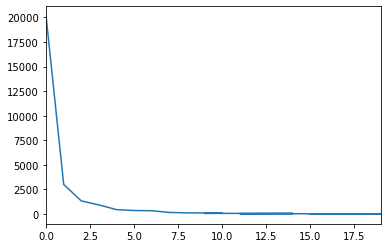

In [175]:
BR_WAR_all_FA_df["Allstar_times"].value_counts().plot()

## is_當年年資不超過6年

In [176]:
Yrs_less_6_mask = BR_WAR_all_FA_df["Yrs_BR"]<=6
BR_WAR_all_FA_df.loc[: , "is_Yrs_less_6"] = False
BR_WAR_all_FA_df.loc[Yrs_less_6_mask , "is_Yrs_less_6"] = True

In [177]:
BR_WAR_all_FA_df["is_Yrs_less_6"].value_counts()

True     18578
False     8438
Name: is_Yrs_less_6, dtype: int64

In [178]:
BR_WAR_all_FA_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27016 entries, 0 to 27015
Data columns (total 30 columns):
G                    27016 non-null int64
age                  27016 non-null float64
lg_ID                27016 non-null object
mlb_ID               27016 non-null float64
name_common          27016 non-null object
player_ID            27016 non-null object
salary_BR            17014 non-null float64
stint_ID             27016 non-null int64
team_ID              27016 non-null object
type                 27016 non-null object
year_ID              27016 non-null int64
POS                  27016 non-null object
salary_LM            8247 non-null float64
salary_max           17110 non-null float64
salary_max_delf      17110 non-null float64
WAR                  27016 non-null float64
Yrs_BR               27016 non-null int64
FA_key               27016 non-null object
Date                 2908 non-null object
To Team ID           2908 non-null object
Yrs_FA               2908 non-n

## 輸出

In [180]:
BR_WAR_all_FA_df_pitch = BR_WAR_all_FA_df[BR_WAR_all_FA_df['type'].isin(["pitch"])].reset_index(drop=True)
BR_WAR_all_FA_df_bat = BR_WAR_all_FA_df[BR_WAR_all_FA_df['type'].isin(["bat"])].reset_index(drop=True)

In [181]:
BR_WAR_all_FA_df_pitch.to_stata('pitch_WAR.dta')
BR_WAR_all_FA_df_bat.to_stata('bat_WAR.dta')

formtoXlsx(BR_WAR_all_FA_df_pitch, "pitch_WAR")
formtoXlsx(BR_WAR_all_FA_df_bat, "bat_WAR")

C:\Users\Daguan\miniconda3\lib\site-packages\pandas\io\stata.py:2303: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    b'To Team ID'   ->   To_Team_ID

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  warnings.warn(ws, InvalidColumnName)


 ==輸出備份xlsx== ::: pitch_WAR_20210313_14.55.54.xlsx
 ==輸出備份xlsx== ::: bat_WAR_20210313_14.56.45.xlsx


# STATA Tips

stata [固定效果model](https://www.stata.com/features/overview/linear-fixed-and-random-effects-models/) 

虛擬變數製作(is_XX球隊) >> stata [建立虛擬變數](https://www.stata.com/support/faqs/data-management/creating-dummy-variables/)